In [1]:
import pandas as pd
import numpy as np
import dask.array as da


In [3]:
y_train = np.load("../nn/y_train.npy")
y_dev = np.load("../nn/y_dev.npy")
cut_point = np.quantile(y_train, 0.999)
print(cut_point)
train_cut = (y_train < cut_point)
dev_cut = (y_dev < cut_point)

349.55506000001685


In [4]:
y_train = da.from_array(y_train)
y_dev = da.from_array(y_dev)

In [5]:
X_dev_base = da.from_array(np.load("../nn/X_dev_base.npy"))
X_dev_neighbors = da.from_array(np.load("../nn/X_dev_neighbors.npy"))
dev = da.concatenate((X_dev_base[dev_cut],X_dev_neighbors[dev_cut]), axis = 1)

In [7]:
from joblib import load

rf = load("../nn/201901103_RF.joblib")

In [8]:
preds = rf.predict(dev)

In [10]:
col_names = feature_names = ['epa_pm25_value', 'humidity', 'temperature', 
                             'wind_x', 'wind_y', 'ndvi', 'elevation'] + [f'neighbor_{m}' for m in range(0,24)] + ['actual', 'preds']


In [15]:
cat = da.concatenate((dev, y_dev[dev_cut].reshape((272464,1)), preds.reshape((272464,1))), axis = 1)

In [21]:
df = pd.DataFrame(np.array(cat), columns = col_names)

In [22]:
df.head()

,epa_pm25_value,humidity,temperature,wind_x,wind_y,ndvi,elevation,neighbor_0,neighbor_1,neighbor_2,...,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,neighbor_21,neighbor_22,neighbor_23,actual,preds
0,21.733333,38.000000,7.300000e+01,0.000000,0.000000,2166.0,44.812019,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.0,6.97,7.0959
1,2.816667,59.000000,7.400000e+01,2.500000,4.330127,1437.0,17.746395,0.0,0.0,6.30,...,0.0,0.0,0.0,0.00,3.21,3.885,0.00,0.0,1.06,5.0053
2,5.900000,59.928571,3.834799e+07,1.910130,-10.832885,3327.0,48.030422,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.0,3.76,4.8004
3,4.300000,65.295775,3.024630e+07,3.420201,-9.396926,5607.0,239.731155,0.0,0.0,0.00,...,0.0,0.0,0.0,3.47,0.00,0.000,0.00,0.0,7.43,6.3496
4,10.566667,53.000000,7.300000e+01,0.000000,0.000000,3392.0,25.501652,0.0,0.0,4.67,...,0.0,0.0,0.0,0.00,0.00,0.000,3.32,0.0,6.75,6.8899


In [23]:
df['abs_error'] = np.abs(df.actual - df.preds)

In [24]:
df['sq_error'] = (df.actual - df.preds)**2

In [25]:
def sq_log(line):
    return (np.log((line.actual+1)/(line.preds+1)))**2

df['sq_log_error'] = df.apply(sq_log, axis = 1)

In [26]:
df.to_csv("errors.csv", index = False)

In [2]:
## restart kernel
errors = pd.read_csv("errors.csv")

In [3]:
errors.columns

Index(['epa_pm25_value', 'humidity', 'temperature', 'wind_x', 'wind_y', 'ndvi',
       'elevation', 'neighbor_0', 'neighbor_1', 'neighbor_2', 'neighbor_3',
       'neighbor_4', 'neighbor_5', 'neighbor_6', 'neighbor_7', 'neighbor_8',
       'neighbor_9', 'neighbor_10', 'neighbor_11', 'neighbor_12',
       'neighbor_13', 'neighbor_14', 'neighbor_15', 'neighbor_16',
       'neighbor_17', 'neighbor_18', 'neighbor_19', 'neighbor_20',
       'neighbor_21', 'neighbor_22', 'neighbor_23', 'actual', 'preds',
       'abs_error', 'sq_error', 'sq_log_error'],
      dtype='object')

In [10]:
def n_neighbors(line):
    c = 0
    for n in range(24):
        if line[f"neighbor_{n}"] > 0:
            c +=1
    return c

errors['n_neighbors'] = errors.apply(n_neighbors, axis = 1)

In [13]:
cor = errors.corr()[['actual', 'preds','abs_error', 'sq_error', 'sq_log_error', 'n_neighbors']]

In [15]:
cor.sort_values(by=['n_neighbors'])

,actual,preds,abs_error,sq_error,sq_log_error,n_neighbors
ndvi,-0.027310,-0.031537,-0.015074,-0.003927,-0.013785,-0.171349
wind_y,0.081375,0.088560,0.064835,0.016913,0.040568,-0.116909
epa_pm25_value,0.737331,0.812150,0.359705,0.136006,0.071483,-0.069844
abs_error,0.573303,0.440517,1.000000,0.771570,0.507351,-0.056365
actual,1.000000,0.936137,0.573303,0.333270,0.016366,-0.052569
sq_log_error,0.016366,0.013515,0.507351,0.344061,1.000000,-0.051156
preds,0.936137,1.000000,0.440517,0.172543,0.013515,-0.050160
temperature,-0.009578,-0.010292,-0.007246,-0.002196,0.001579,-0.039350
elevation,-0.016054,-0.020454,-0.018588,-0.000477,-0.013572,-0.023769
sq_error,0.333270,0.172543,0.771570,1.000000,0.344061,-0.018905


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([8.9153e+04, 7.9355e+04, 5.5023e+04, 2.5645e+04, 1.3109e+04,
        6.7070e+03, 2.5750e+03, 5.5700e+02, 2.5400e+02, 8.6000e+01]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

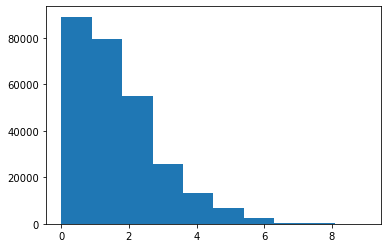

In [17]:
plt.hist(errors['n_neighbors'])

In [19]:
errors['sq_error'].mean()

33.615105376912794

In [18]:
errors.groupby('n_neighbors').agg({'abs_error':'mean', 'sq_error':'mean','sq_log_error':'mean'})

,abs_error,sq_error,sq_log_error
n_neighbors,,,
0,2.735102,53.562260,0.249268
1,2.229151,33.552664,0.213634
2,1.924275,16.397583,0.202562
3,1.985467,20.418657,0.203661
4,1.927897,13.049044,0.163226
5,1.822972,13.620742,0.143603
6,1.773583,11.643272,0.130776
7,1.251484,4.525655,0.102477
8,0.748148,0.919887,0.098635


In [24]:
errors[['abs_error','sq_error', 'sq_log_error']].describe()

,abs_error,sq_error,sq_log_error
count,272464.000000,272464.000000,272464.000000
mean,2.277541,33.615105,0.216812
std,5.331793,720.788679,0.522319
min,0.000000,0.000000,0.000000
25%,0.576100,0.331891,0.014892
50%,1.258800,1.584577,0.069577
75%,2.462125,6.062060,0.223545
max,330.581633,109284.216297,29.208174


In [43]:
def has_r1(line, inner):
    c = 0
    if inner == True:
        nns = [6,7,8,11,12,15,16,17]
    else:
        nns = [0,1,2,3,4,5,9,10,13,14,18,19,20,21,22,23]
        
    for n in nns:
        if line[f'neighbor_{n}'] > 0:
            c +=1
    return c

errors['r1_neighbors'] = errors.apply(lambda l: has_r1(l, inner = True), axis = 1)
errors['r2_neighbors'] = errors.apply(lambda l: has_r1(l, inner = False), axis = 1)

In [44]:
errors.groupby('r1_neighbors').agg({'abs_error':'mean', 'sq_error':'mean','sq_log_error':'mean'})

,abs_error,sq_error,sq_log_error
r1_neighbors,,,
0,2.427601,39.564447,0.227379
1,1.927938,20.439662,0.202534
2,1.922678,15.847479,0.150192
3,1.867884,25.283830,0.176856


In [45]:
errors.groupby('r2_neighbors').agg({'abs_error':'mean', 'sq_error':'mean','sq_log_error':'mean'})

,abs_error,sq_error,sq_log_error
r2_neighbors,,,
0,2.600282,47.294142,0.238798
1,2.120295,30.763027,0.211781
2,1.981791,17.840912,0.203254
3,1.998036,13.904071,0.169347
4,1.966438,14.564995,0.164648
5,1.439893,4.964344,0.121603
6,1.014247,2.478255,0.121224
7,0.723876,0.820413,0.088502


In [57]:
errors.groupby(['r1_neighbors', 'r2_neighbors']) \
    .agg({'abs_error':'mean', 'sq_error':'mean','sq_log_error':'mean'}) \
     .reset_index() \
     .sort_values(by=['sq_error'])

,r1_neighbors,r2_neighbors,abs_error,sq_error,sq_log_error
7,0,7,0.749275,0.780422,0.071008
23,2,7,0.708087,0.784611,0.086139
15,1,7,0.740610,0.869672,0.093476
22,2,6,0.750959,0.938616,0.100560
14,1,6,0.763790,0.972874,0.099009
27,3,3,1.485491,3.904882,0.136143
5,0,5,1.448997,4.285527,0.134027
6,0,6,1.370643,4.588288,0.150821
13,1,5,1.412394,5.352313,0.112854
21,2,5,1.457060,6.025013,0.104508


In [58]:
ninetieth = np.quantile(errors['sq_error'], 0.90)
high_error = errors[errors.sq_error > ninetieth]

In [59]:
ninetieth

20.43763264000001

In [60]:
errors[['epa_pm25_value', 'humidity', 'temperature', 'wind_x', 'wind_y', 'ndvi',
       'elevation', 'n_neighbors']].describe()

,epa_pm25_value,humidity,temperature,wind_x,wind_y,ndvi,elevation,n_neighbors
count,272464.000000,272464.000000,2.724640e+05,272464.000000,272464.000000,272464.000000,272464.000000,272464.000000
mean,8.364591,54.608954,7.743004e+06,-0.560750,-3.377792,3419.511803,76.069928,1.374354
std,9.893865,18.786724,1.260235e+08,4.062264,6.260046,1790.447597,75.624764,1.402901
min,-2.900000,2.000000,-2.320000e+02,-24.000000,-33.483464,-2000.000000,-0.282349,0.000000
25%,4.400000,45.000000,6.100000e+01,-2.500000,-7.000000,2230.000000,17.964766,0.000000
50%,6.800000,56.000000,6.600000e+01,0.000000,-2.298133,2998.000000,49.219090,1.000000
75%,10.000000,64.000000,7.300000e+01,2.000000,0.000000,4795.000000,102.575966,2.000000
max,234.333333,255.000000,2.147484e+09,30.070164,23.000000,7597.000000,330.234375,9.000000


In [61]:
high_error[['epa_pm25_value', 'humidity', 'temperature', 'wind_x', 'wind_y', 'ndvi',
       'elevation', 'n_neighbors']].describe()

,epa_pm25_value,humidity,temperature,wind_x,wind_y,ndvi,elevation,n_neighbors
count,27247.000000,27247.000000,2.724700e+04,27247.000000,27247.000000,27247.000000,27247.000000,27247.000000
mean,16.474419,56.514830,4.297920e+06,-0.521806,-2.011457,3319.474548,69.635346,1.139135
std,24.252788,16.564563,9.199695e+07,3.640604,5.664027,1887.994405,70.381969,1.302028
min,-2.900000,7.000000,-2.320000e+02,-24.000000,-33.483464,-2000.000000,-0.282349,0.000000
25%,6.133333,48.000000,6.000000e+01,-2.394141,-5.142301,1937.000000,17.746395,0.000000
50%,9.633333,59.000000,6.400000e+01,0.000000,0.000000,2913.000000,48.030422,1.000000
75%,14.200000,65.000000,6.900000e+01,1.928363,1.389185,4803.000000,93.946861,2.000000
max,234.333333,255.000000,2.147484e+09,12.256711,18.385067,7597.000000,330.234375,7.000000


seems like the high error set includes most extreme values ...

(array([2.366e+04, 1.465e+03, 5.130e+02, 7.480e+02, 4.440e+02, 2.540e+02,
        7.200e+01, 8.500e+01, 2.000e+00, 4.000e+00]),
 array([ -2.9       ,  20.82333333,  44.54666667,  68.27      ,
         91.99333333, 115.71666667, 139.44      , 163.16333333,
        186.88666667, 210.61      , 234.33333333]),
 <a list of 10 Patch objects>)

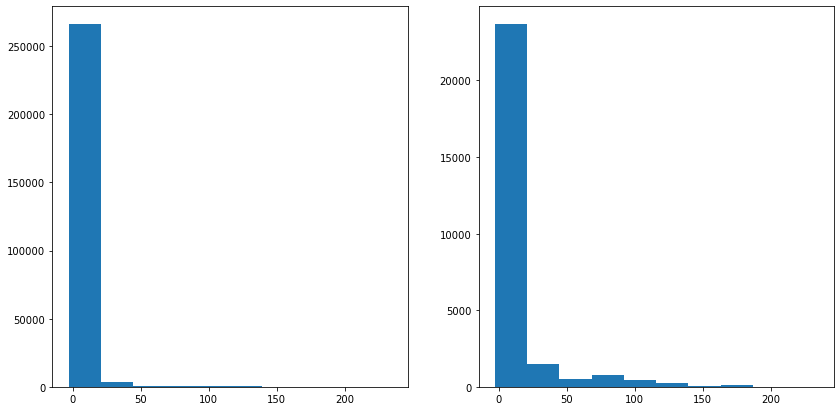

In [62]:
f,a = plt.subplots(ncols =2, figsize = (14,7))
a[0].hist(errors['epa_pm25_value'])
a[1].hist(high_error['epa_pm25_value'])

(0, 12000)

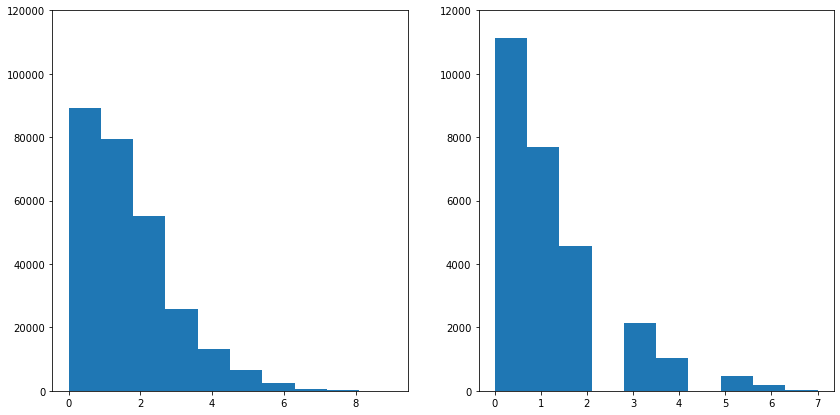

In [63]:
f,a = plt.subplots(ncols =2, figsize = (14,7))
a[0].hist(errors['n_neighbors'])
a[1].hist(high_error['n_neighbors'])
a[0].set_ylim(0,120000)
a[1].set_ylim(0,12000)

(array([9217., 7988., 3622., 2811.,  566.,  860.,  727.,  664.,  365.,
         427.]),
 array([-2.82349229e-01,  3.27693232e+01,  6.58209956e+01,  9.88726680e+01,
         1.31924340e+02,  1.64976013e+02,  1.98027685e+02,  2.31079358e+02,
         2.64131030e+02,  2.97182703e+02,  3.30234375e+02]),
 <a list of 10 Patch objects>)

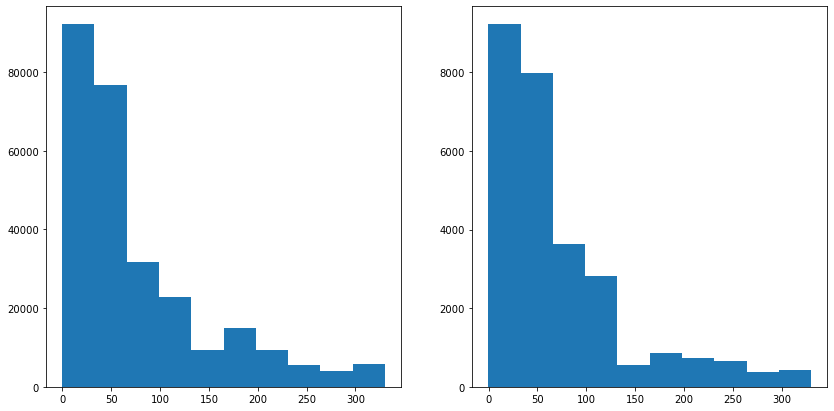

In [64]:
f,a = plt.subplots(ncols =2, figsize = (14,7))
a[0].hist(errors['elevation'])
a[1].hist(high_error['elevation'])

(0, 22000)

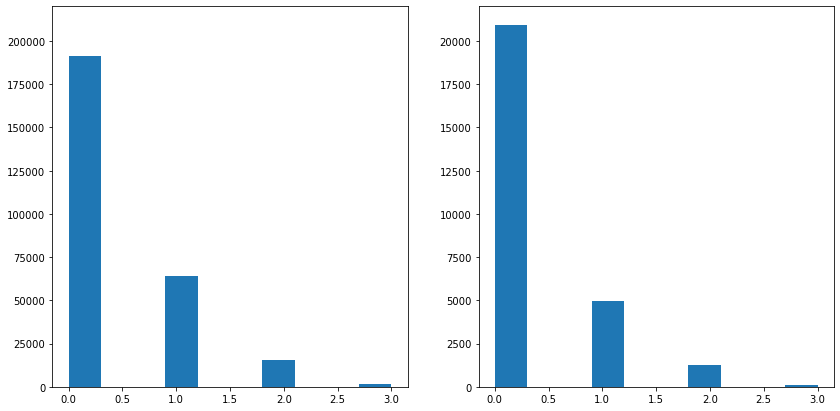

In [67]:
f,a = plt.subplots(ncols =2, figsize = (14,7))
a[0].hist(errors['r1_neighbors'])
a[1].hist(high_error['r1_neighbors'])
a[0].set_ylim(0,220000)
a[1].set_ylim(0,22000)

(0, 14000)

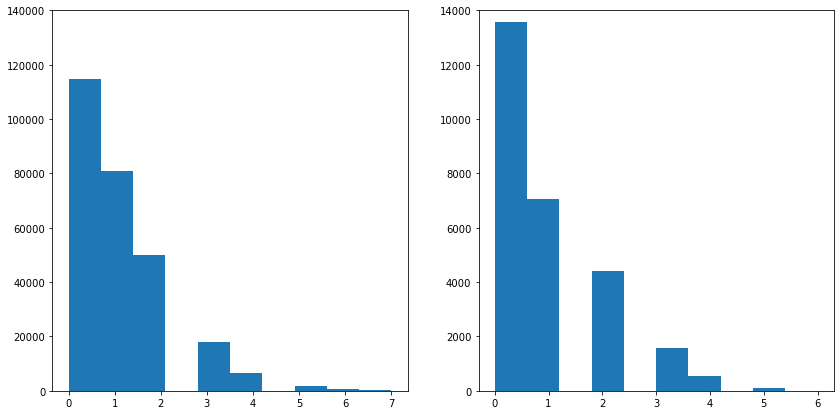

In [68]:
f,a = plt.subplots(ncols =2, figsize = (14,7))
a[0].hist(errors['r2_neighbors'])
a[1].hist(high_error['r2_neighbors'])
a[0].set_ylim(0,140000)
a[1].set_ylim(0,14000)